In [28]:
import nltk
import re
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from collections import Counter
from gensim.utils import simple_preprocess
from gensim.models import word2vec
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import SVC
from sklearn.cluster import AffinityPropagation
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.manifold import TSNE
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.exceptions import UndefinedMetricWarning

warnings.filterwarnings("ignore", category=UndefinedMetricWarning)
np.seterr(divide='ignore', invalid='ignore')
pd.options.display.max_colwidth = 200

lemmatizer = WordNetLemmatizer()

In [22]:
data = pd.read_csv('./DS2_clean.csv', encoding='utf-8')
data.head()


,text,category,label
0,!!! RT @mayasolovely: As a woman you shouldn't complain about cleaning up your house. &amp; as a man you should always take the trash out...,normal,False
1,!!!!! RT @mleew17: boy dats cold...tyga dwn bad for cuffin dat hoe in the 1st place!!,offensive_language,True
2,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby4life: You ever fuck a bitch and she start to cry? You be confused as shit,offensive_language,True
3,!!!!!!!!! RT @C_G_Anderson: @viva_based she look like a tranny,offensive_language,True
4,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you hear about me might be true or it might be faker than the bitch who told it to ya &#57361;,offensive_language,True


In [23]:
data.describe()
data['label'] = data['label'].apply(lambda label: 0 if label == False else 1)

Percentage of Offensive language: 83.2%


Text(0.5, 1.0, 'Empirical distribution of the labels')

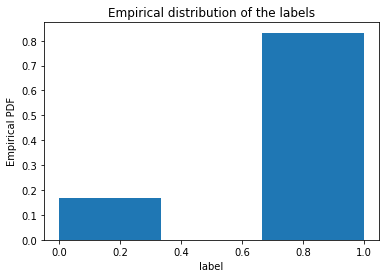

In [24]:
# Empirical distribution of the labels
print('Percentage of Offensive language: {0}%'.format(round(100 * data['label'].sum() / len(data['label']), 2)))
plt.hist(data['label'], bins=3, weights=np.ones(len(data['label'])) / len(data['label']))
plt.xlabel('label')
plt.ylabel('Empirical PDF')
plt.title('Empirical distribution of the labels')

In [25]:
data['text_length'] = data['text'].apply(lambda text: len(text))
data.sort_values(by='text_length', ascending=False)
# most of offensie are long sentences? 


,text,category,label,text_length
17865,RT @TrxllLegend: One good girl is worth a thousand bitches\n\n&#128112; = &#128109;&#128109;&#128109;&#128109;&#128109;&#128109;&#128109;&#128109;&#128109;&#128109;&#128109;&#128109;&#128109;&#128...,offensive_language,1,754
13402,No summer school? &#128515;&#128515;&#128515;&#128515;&#128515;&#128515;&#128515;&#128515;&#128515;&#128515;&#128515;&#128515;&#128515;&#128515;&#128515;&#128515;&#128515;&#128515;&#128515;&#12851...,offensive_language,1,657
1596,&#8220;@Untouchable_T: Never seen so many perfect bitches til I made a Twitter &#128564; but &#128056;&#9749;&#65039;&#8221;&#128175;&#128175;&#128175;&#128175;&#128175;&#128175;&#128175;&#128175;...,offensive_language,1,637
16539,RT @Mr_MshkL: &#1589;&#1608;&#1585;&#1577; &#1604;&#1591;&#1575;&#1574;&#1585; &#1575;&#1604;&#1603;&#1575;&#1585;&#1583;&#1610;&#1606;&#1575;&#1604; &#1575;&#1604;&#1571;&#1581;&#1605;&#1585; &#1...,normal,0,522
18886,RT @digiflorals: bitch do it look like I care \n\n&#12288; N\n&#12288;&#12288; O\n&#12288;&#12288;&#12288; O\n&#12288;&#12288;&#12288;&#12288; o\n&#12288;&#12288;&#12288;&#12288;&#12288;o\n&#12288...,offensive_language,1,455
...,...,...,...,...
8944,Emd hoe,offensive_language,1,7
24619,u a hoe,offensive_language,1,7
24393,retard.,offensive_language,1,7
24364,pussy,offensive_language,1,5


Text(0.5, 1.0, 'Empirical distribution of the message lengths')

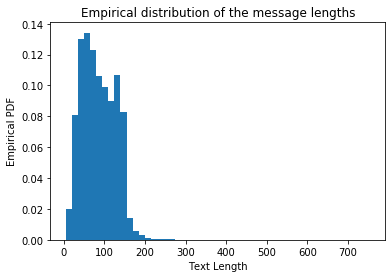

In [26]:
plt.hist(data['text_length'], bins=50, weights=np.ones(len(data))/len(data))
plt.xlabel('Text Length')
plt.ylabel('Empirical PDF')
plt.title('Empirical distribution of the message lengths')

In [27]:
def preprocess(text):
    result = []
    for token in simple_preprocess(text):
        if token not in STOPWORDS and len(token) > 3:
            result.append(lemmatizer.lemmatize(token, pos='v'))
    return " ".join(result).strip()

def clean_tweets(df):
    URL = r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\), ]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    MENTION = r'@[A-Za-z0-9_]+'
    RT = r'RT '
    LINE = r'\n'
    AND = r'&amp;'
    TRUNCATED = r'[^\s]+…'
    EMOJI = r'\"\s|\s\"|&#\d+|@[A-Za-z0-9_]+|[:;#.&,!]|http'

    pattern_list = [URL, MENTION, LINE, AND, TRUNCATED, EMOJI]

    for i, t in df.items():
        for p in pattern_list:
            pattern = re.compile(p, re.IGNORECASE)
            t = pattern.sub(" ", t).strip()
        # preprocessing text
        t = preprocess(t)
        df[i] = t

clean_tweets(data['text'])

/home/pwnslinger/.virtualenvs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [8]:
# extract spams and hams
offensive = data['text'].iloc[(data['label'] == 1).values]
normal = data['text'].iloc[(data['label'] == 0).values]
print(offensive[:10])
print(normal[:10])

1                    dats cold tyga cuffin place
2             dawg fuck bitch start confuse shit
3                               look like tranny
4                shit hear true faker bitch tell
5     shit blow claim faithful somebody fuck hoe
6                             hate bitch shit go
7             cause tire bitch come skinny girls
8                                    bitch thats
9             hobbies include fight mariam bitch
10      keeks bitch curve walk conversation like
Name: text, dtype: object
0          woman shouldn complain clean house trash
40              momma say pussy cat inside doghouse
63                                 woof woof scally
66                                   woof woof sole
67                            lemmie oreo dish oreo
70             eggplant emoji look like scream lmao
75       baby monkey bathtime awwwwe soooo adorable
115              baseball season yankees love start
118                      early bird night wise worm
119    overdose 

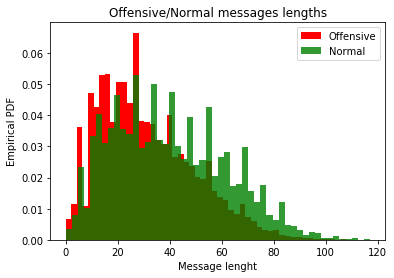

In [9]:
plt.hist(offensive.apply(lambda x: len(x)),
         bins=50,
         weights=np.ones(len(offensive)) / len(offensive),
         facecolor='r',
         label='Offensive')
plt.hist(normal.apply(lambda x: len(x)),
         bins=50,
         weights=np.ones(len(normal)) / len(normal),
         facecolor='g',
         alpha=0.8,
         label='Normal')
plt.xlabel('Message lenght')
plt.ylabel('Empirical PDF')
plt.title('Offensive/Normal messages lengths')
def preprocess(text):
    result = []
    for token in simple_preprocess(text):
        if token not in STOPWORDS and len(token) > 3:
            result.append(lemmatizer.lemmatize(token, pos='v'))
    return " ".join(result).strip()
plt.legend()

In [10]:
# most common words in spam and ham
offensive_tokens = []
for word in offensive:
    offensive_tokens += nltk.tokenize.word_tokenize(word)
normal_tokens = []
for word in normal:
    normal_tokens += nltk.tokenize.word_tokenize(word)
print(offensive_tokens[:10])
print(normal_tokens[:10])


['dats', 'cold', 'tyga', 'cuffin', 'place', 'dawg', 'fuck', 'bitch', 'start', 'confuse']
['woman', 'shouldn', 'complain', 'clean', 'house', 'trash', 'momma', 'say', 'pussy', 'cat']


In [11]:
most_common_tokens_in_offensive = Counter(offensive_tokens).most_common(20)
most_common_tokens_in_normal = Counter(normal_tokens).most_common(20)
print(most_common_tokens_in_offensive)
print(most_common_tokens_in_normal)

[('bitch', 11465), ('like', 2548), ('hoe', 2390), ('fuck', 2267), ('pussy', 2152), ('shit', 1306), ('nigga', 1228), ('know', 840), ('niggas', 790), ('love', 667), ('want', 640), ('look', 639), ('na', 575), ('think', 570), ('faggot', 544), ('go', 530), ('talk', 520), ('say', 498), ('tell', 488), ('need', 471)]
[('trash', 698), ('bird', 476), ('like', 314), ('charlie', 259), ('yankees', 225), ('yellow', 222), ('look', 132), ('color', 125), ('think', 116), ('monkey', 115), ('go', 114), ('ghetto', 113), ('want', 113), ('know', 109), ('game', 106), ('love', 100), ('good', 95), ('mock', 93), ('say', 90), ('time', 85)]


In [12]:
data, test_data = train_test_split(data, test_size=0.3)
print('Train-valid data length: {0}'.format(len(data)))
print('Test data length: {0}'.format(len(test_data)))


Train-valid data length: 17348
Test data length: 7435


In [13]:
# build word2vec model
wpt = nltk.WordPunctTokenizer()
tokenized_corpus = [wpt.tokenize(document) for document in data['text']]

# Set values for various parameters
feature_size = 100    # Word vector dimensionality
window_context = 10  # Context window size
min_word_count = 1   # Minimum word count
sample = 1e-3   # Downsample setting for frequent words

w2v_model = word2vec.Word2Vec(tokenized_corpus, size=feature_size, 
                          window=window_context, min_count=min_word_count,
                          sample=sample, iter=50)

w2v = dict(zip(w2v_model.wv.index2word, w2v_model.wv.syn0))

/home/pwnslinger/.virtualenvs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  from ipykernel import kernelapp as app


In [14]:
# view similar words based on gensim's model
similar_words = {search_term: [item[0] for item in w2v_model.wv.most_similar([search_term], topn=5)]
                  for search_term in ['trash', 'niggers', 'bitch', 'taco', 'fuck','fugly']}
similar_words

{'trash': ['thrift', 'accnt', 'unsold', 'items', 'doom'],
 'niggers': ['knooooooow', 'honkey', 'jews', 'stereotype', 'ignorant'],
 'bitch': ['iont', 'relationship', 'cheapwine', 'shantrell', 'inbox'],
 'taco': ['yusa', 'birdman', 'bearfaced', 'crazier', 'thunderball'],
 'fuck': ['goddam', 'tryin', 'quit', 'aight', 'mugshot'],
 'fugly': ['farmers', 'kedollarsignha', 'firefighter', 'juvie', 'differences']}

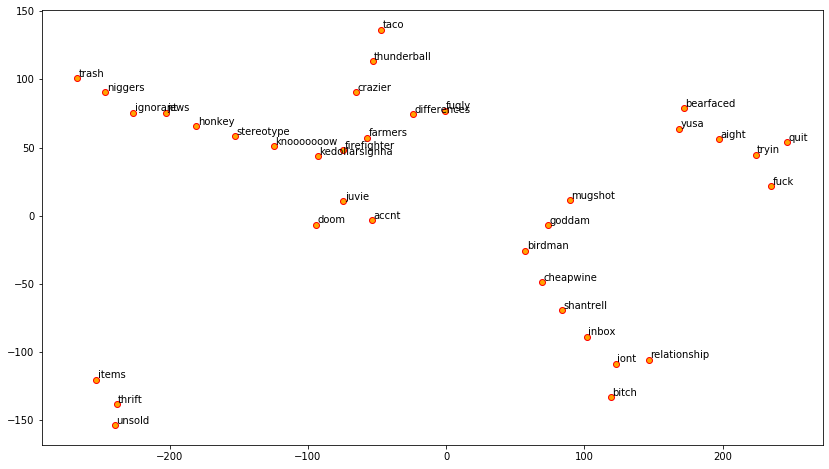

In [15]:
words = sum([[k] + v for k, v in similar_words.items()], [])
wvs = w2v_model.wv[words]

tsne = TSNE(n_components=2, random_state=0, n_iter=10000, perplexity=2)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(wvs)
labels = words

plt.figure(figsize=(14, 8))
plt.scatter(T[:, 0], T[:, 1], c='orange', edgecolors='r')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

In [16]:
class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        self.dim = len(word2vec.values())

    def fit(self, X, y):
        return self

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])

In [17]:
class TfidfEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.word2weight = None
        self.dim = len(word2vec.values())

    def fit(self, X, y):
        tfidf = TfidfVectorizer(analyzer=lambda x: x)
        tfidf.fit(X)
        # if a word was never seen - it must be at least as infrequent
        # as any of the known words - so the default idf is the max of 
        # known idf's
        max_idf = max(tfidf.idf_)
        self.word2weight = defaultdict(
            lambda: max_idf,
            [(w, tfidf.idf_[i]) for w, i in tfidf.vocabulary_.items()])

        return self

    def transform(self, X):
        return np.array([
                np.mean([self.word2vec[w] * self.word2weight[w]
                         for w in words if w in self.word2vec] or
                        [np.zeros(self.dim)], axis=0)
                for words in X
            ])


In [18]:
class Classifier(object):
    
    def __init__(self, model, param):
        self.model = model
        self.param = param
        self.gs = GridSearchCV(self.model, self.param, cv=5, error_score=0, refit=True)        

    def fit(self, X, y):        
        return self.gs.fit(X, y)

    def predict(self, X):
        return self.gs.predict(X)

In [19]:
clf_models = {
    'Naive Bayes': GaussianNB(), 
    'SVC': SVC(),
    'Decision Tree': DecisionTreeClassifier(),  
    'Perceptron': MLPClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'Logistic Regression': LogisticRegression(),
    'Ada Boost': AdaBoostClassifier(),
    'MLP Classifier': MLPClassifier()
}

clf_params = {
    'Naive Bayes': { }, 
    'SVC': { 'kernel': ['linear', 'rbf'] },
    'Decision Tree': { 'min_samples_split': [2, 5] }, 
    'Perceptron': { 'activation': ['tanh', 'relu'] },
    'Gradient Boosting': { 'min_samples_split': [2, 5] },
    'MLP Classifier': { 'hidden_layer_sizes': [100,100]}
}

X_train, X_test, y_train, y_test = train_test_split(data['text'], data['label'], test_size=0.2, shuffle=True)



In [ ]:
for key in clf_models.keys():
    
    clf = Pipeline([('Word2Vec vectorizer', MeanEmbeddingVectorizer(w2v)), ('Classifier', Classifier(clf_models[key], clf_params[key]))])
    
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    print(key, ':')
    print("Accuracy: %1.3f \tPrecision: %1.3f \tRecall: %1.3f \t\tF1: %1.3f\n" % (accuracy_score(y_test, y_pred), precision_score(y_test, y_pred, average='macro'), recall_score(y_test, y_pred, average='macro'), f1_score(y_test, y_pred, average='macro')))